In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [00:25<00:00, 217MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
import os, shutil
import skimage
import matplotlib.image as mpimg
import random
import skimage.segmentation
%matplotlib inline
from glob import glob
# plt.style.use('ggplot')
import kagglehub
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import cv2
from tqdm.notebook import tqdm
import time
from datetime import datetime
from IPython import display
# from ultralytics import YOLO
import multiprocessing as mp
from skimage.morphology import disk
from skimage.filters import rank

In [ ]:
# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(path, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
df = pd.read_csv(f'{path}/HAM10000_metadata.csv')

# Creating New Columns for better readability
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/root/.cache/kagglehub/datasets/kmader/skin-ca...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/root/.cache/kagglehub/datasets/kmader/skin-ca...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/root/.cache/kagglehub/datasets/kmader/skin-ca...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/root/.cache/kagglehub/datasets/kmader/skin-ca...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/root/.cache/kagglehub/datasets/kmader/skin-ca...,Benign keratosis-like lesions,2


In [ ]:
df['age'].fillna((df['age'].mean()), inplace=True)

<ipython-input-6-6c9f6c8fc82c>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna((df['age'].mean()), inplace=True)


In [ ]:
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


## EDA

<Axes: xlabel='dx'>

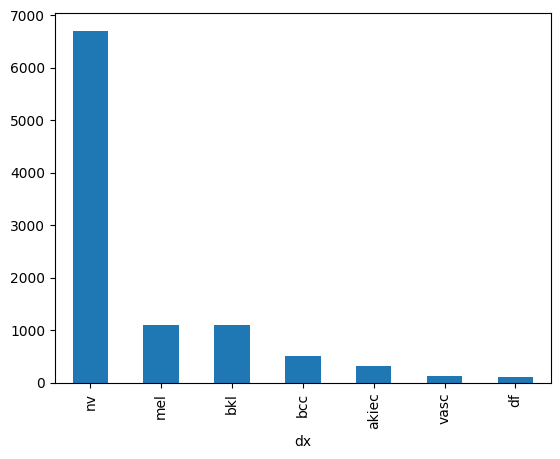

In [ ]:
df['dx'].value_counts().plot(kind='bar')

## Pre processing

In [ ]:
from PIL import Image
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/root/.cache/kagglehub/datasets/kmader/skin-ca...,Benign keratosis-like lesions,2,"[[[187, 150, 192], [190, 154, 195], [192, 156,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/root/.cache/kagglehub/datasets/kmader/skin-ca...,Benign keratosis-like lesions,2,"[[[24, 13, 22], [25, 13, 23], [24, 14, 23], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/root/.cache/kagglehub/datasets/kmader/skin-ca...,Benign keratosis-like lesions,2,"[[[186, 127, 135], [188, 129, 137], [191, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/root/.cache/kagglehub/datasets/kmader/skin-ca...,Benign keratosis-like lesions,2,"[[[23, 11, 15], [24, 11, 18], [24, 10, 19], [2..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/root/.cache/kagglehub/datasets/kmader/skin-ca...,Benign keratosis-like lesions,2,"[[[125, 83, 105], [132, 89, 112], [138, 93, 11..."


In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Checking the image size distribution
df['image'].map(lambda x: x.shape).value_counts()

,count
image,
"(224, 224, 3)",10015


In [ ]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [ ]:
features

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train, test, and validation sets
x_train_all, x_temp_all, y_train_all, y_temp_all = train_test_split(features, target, test_size=0.2, random_state=42)
x_test_all, x_val_all, y_test_all, y_val_all = train_test_split(x_temp_all, y_temp_all, test_size=0.5, random_state=42)

In [ ]:
import numpy as np

# Convert the data to a numpy array
x_train_images = np.array(x_train_all['image'].tolist())
x_test_images = np.array(x_test_all['image'].tolist())
x_val_images = np.array(x_val_all['image'].tolist())

# Normalize pixel values to range [0, 1] (assuming pixel values are between 0 and 255)
x_train= x_train_images / 255.0
x_test = x_test_images / 255.0
x_val = x_val_images / 255.0


In [ ]:
from tensorflow.keras.utils import to_categorical
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_all, num_classes = 7)
y_test = to_categorical(y_test_all, num_classes = 7)
y_val = to_categorical(y_val_all, num_classes = 7)

In [ ]:
x_train.shape

(8012, 224, 224, 3)

## Helper functions

In [ ]:
# function to use Tensorboard callback to track model's performances
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])

    accuracy = history.history['accuracy']
    val_accuracy = history.history.get('val_accuracy', [])

    epochs = range(len(loss))
    val_epochs = range(len(val_loss))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    if val_loss:
        plt.plot(val_epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    if val_accuracy:
        plt.plot(val_epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

## Model building

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

custom_model = Sequential([
  Conv2D(10, 1, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 1, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 1, activation='relu'),
  Conv2D(10, 1, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(7, activation='softmax')
])

custom_model.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy", keras.metrics.AUC(name="auc")])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
custom_model_history = custom_model.fit(x_train,y_train,
                                        batch_size=32,
                                        epochs=10,
                                        validation_data=(x_val, y_val),
                                        callbacks=[callback, create_tensorboard_callback("skin_dataset", "basic_model")])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Saving TensorBoard log files to: skin_dataset/basic_model/20250312-075700
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.6391 - auc: 0.8726 - loss: 1.1744 - val_accuracy: 0.6627 - val_auc: 0.9196 - val_loss: 0.9964
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6679 - auc: 0.9211 - loss: 0.9697 - val_accuracy: 0.6597 - val_auc: 0.9328 - val_loss: 0.9085
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6752 - auc: 0.9340 - loss: 0.8889 - val_accuracy: 0.6687 - val_auc: 0.9363 - val_loss: 0.8754
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6882 - auc: 0.9388 - loss: 0.8556 - val_accuracy: 0.6766 - val_auc: 0.9392 - val_loss: 0.8557
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6935 - auc: 0.9418 - loss: 0.8355 - val_accuracy: 0.6846 - val_auc: 0.9408 - val_loss: 0.8422
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6991 - auc: 0.9438 - loss: 0.8204 - val_accuracy: 0.6

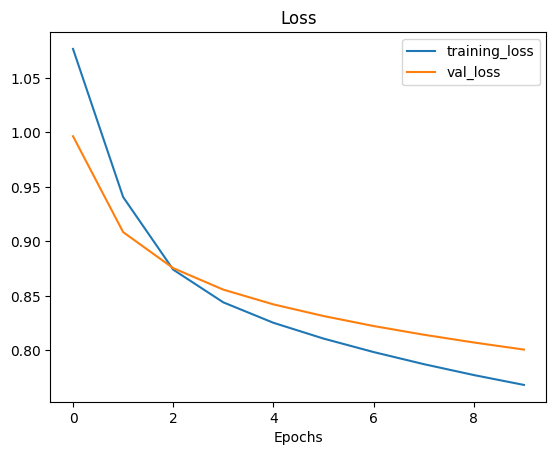

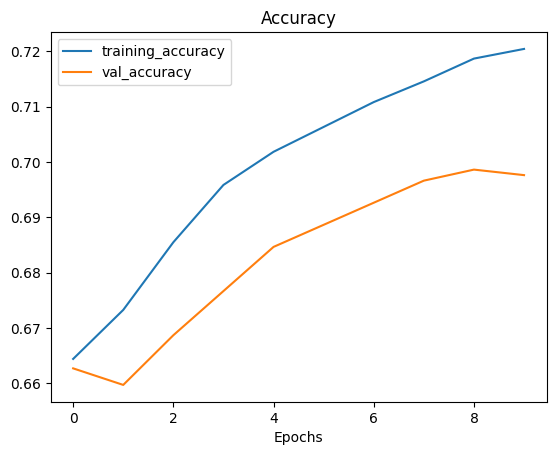

In [ ]:
plot_loss_curves(custom_model_history)

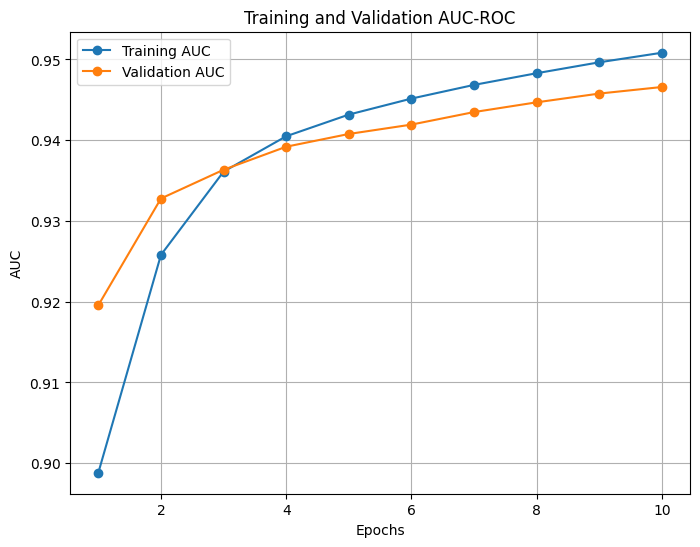

In [ ]:
# Plot the AUC values after training
train_auc = custom_model_history.history["auc"]
val_auc = custom_model_history.history["val_auc"]

epochs = range(1, len(train_auc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_auc, label="Training AUC", marker="o")
plt.plot(epochs, val_auc, label="Validation AUC", marker="o")
plt.title("Training and Validation AUC-ROC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
custom_model.evaluate(x_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6803 - auc: 0.9414 - loss: 0.8324


[0.8068420886993408, 0.7032967209815979, 0.944740355014801]

## variance penalized

In [ ]:
def custom_accuracy(y_true, features_and_pred):
    # Extract predictions from features_and_pred
    predictions = features_and_pred[:, -1:]  # Last column is predictions
    return tf.keras.metrics.binary_accuracy(y_true, predictions)

In [ ]:
import tensorflow as tf

class OptimizedVariancePenalizedLoss(tf.keras.losses.Loss):
    def __init__(self, dense_layer_neurons, variance_weight, feature_sampling_ratio, lambda_, name='optimized_variance_loss'):
        super().__init__(name=name)
        self.variance_weight = variance_weight
        self.feature_sampling_ratio = feature_sampling_ratio
        self.lambda_ = lambda_  # Balancing factor for binary crossentropy loss

    @tf.function
    def call(self, y_true, features_and_pred):
        # Split features and predictions
        features = features_and_pred[:, :-dense_layer_neurons]  # All features except the last column
        predictions = features_and_pred[:, -dense_layer_neurons:]  # Last column is predictions

        # Sample features to reduce computation
        feature_dim = tf.shape(features)[1]
        sample_size = tf.cast(tf.cast(feature_dim, tf.float32) * self.feature_sampling_ratio, tf.int32)
        indices = tf.random.shuffle(tf.range(feature_dim))[:sample_size]
        sampled_features = tf.gather(features, indices, axis=1)

        # Calculate variance for sampled features
        mean = tf.reduce_mean(sampled_features, axis=0, keepdims=True)
        variance = tf.reduce_mean(tf.square(sampled_features - mean))

        if dense_layer_neurons > 2:
            loss = tf.keras.losses.categorical_crossentropy(y_true, predictions)
        else:
            loss = tf.keras.losses.binary_crossentropy(y_true, predictions)

        # Combine binary crossentropy and variance penalty
        total_loss = tf.reduce_mean(self.lambda_ * loss) + self.variance_weight * variance
        return total_loss

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Base CNN model
input_layer = Input(shape=(224, 224, 3))

# Convolutional and Pooling layers
x = Conv2D(10, 1, activation='relu')(input_layer)
x = Conv2D(10, 1, activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(10, 1, activation='relu')(x)
x = Conv2D(10, 1, activation='relu')(x)
x = MaxPool2D()(x)

# Flatten layer
penultimate_features = Flatten()(x)

# Dense layers
predictions = Dense(7, activation='softmax')(penultimate_features)

# Concatenate penultimate features and predictions
features_and_pred = Concatenate(axis=-1)([penultimate_features, predictions])

# Define the complete model
custom_model_penalized = Model(inputs=input_layer, outputs=features_and_pred)

dense_layer_neurons=7
# Custom loss function (ensure `OptimizedVariancePenalizedLoss` and `custom_accuracy` are implemented)
custom_loss = OptimizedVariancePenalizedLoss(dense_layer_neurons, variance_weight=0.01, feature_sampling_ratio=0.2, lambda_=0.5)

custom_model_penalized.compile(
    loss=custom_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[custom_accuracy]
)

# Early stopping callback
callback_penalized = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
custom_model_penalized_history = custom_model_penalized.fit(
    x_train,y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[callback_penalized, create_tensorboard_callback("skin_dataset", "variance_penalized_model")]
)


Saving TensorBoard log files to: skin_dataset/variance_penalized_model/20250312-075946
Epoch 1/10
 77/251 ━━━━━━━━━━━━━━━━━━━━ 3:38:31 75s/step - custom_accuracy: 0.8571 - loss: 0.6666

KeyboardInterrupt: 

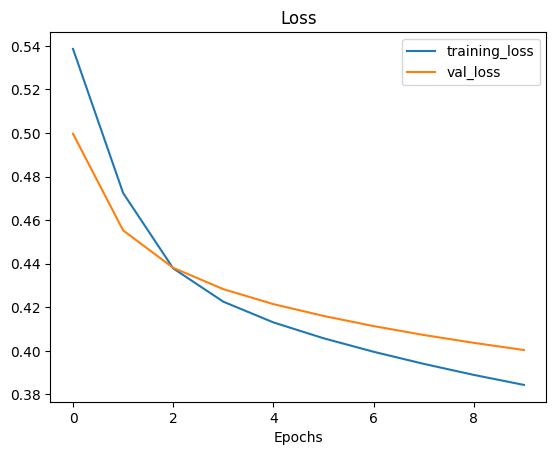

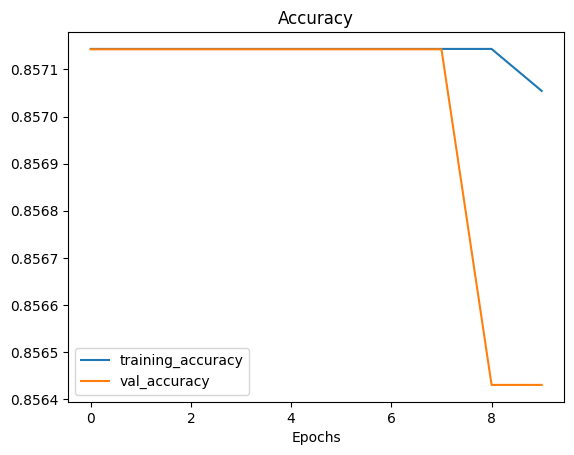

In [ ]:
def plot_loss_curves_custom(history):
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])

    accuracy = history.history['custom_accuracy']
    val_accuracy = history.history.get('val_custom_accuracy', [])

    epochs = range(len(loss))
    val_epochs = range(len(val_loss))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    if val_loss:
        plt.plot(val_epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    if val_accuracy:
        plt.plot(val_epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

plot_loss_curves_custom(custom_model_penalized_history)

In [ ]:
custom_model_penalized.evaluate(x_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - custom_accuracy: 0.8571 - loss: 0.4167


[0.4038826525211334, 0.857142984867096]